In [79]:
import torch, os, math
from math import sqrt
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import MNIST
from torchvision import transforms
tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
train_dataset = MNIST("/media/volume/sdb/data", train=True, download=False, transform=tf)
val_dataset = MNIST("/media/volume/sdb/data", train=False, download=False, transform=tf)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128, 
                                           shuffle=True, drop_last=True, 
                                           num_workers=1, 
                                           pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=128, 
                                         shuffle=False, 
                                         num_workers=1, 
                                         pin_memory=True)

# Set float32 matrix multiplication precision to medium
torch.set_float32_matmul_precision('medium')
print(len(val_dataset))
print(val_dataset[0][0].shape)
images, labels = zip(*[val_dataset[i] for i in range(32)])
images = np.array(images)
print(images.shape)

10000
torch.Size([1, 28, 28])
(32, 1, 28, 28)


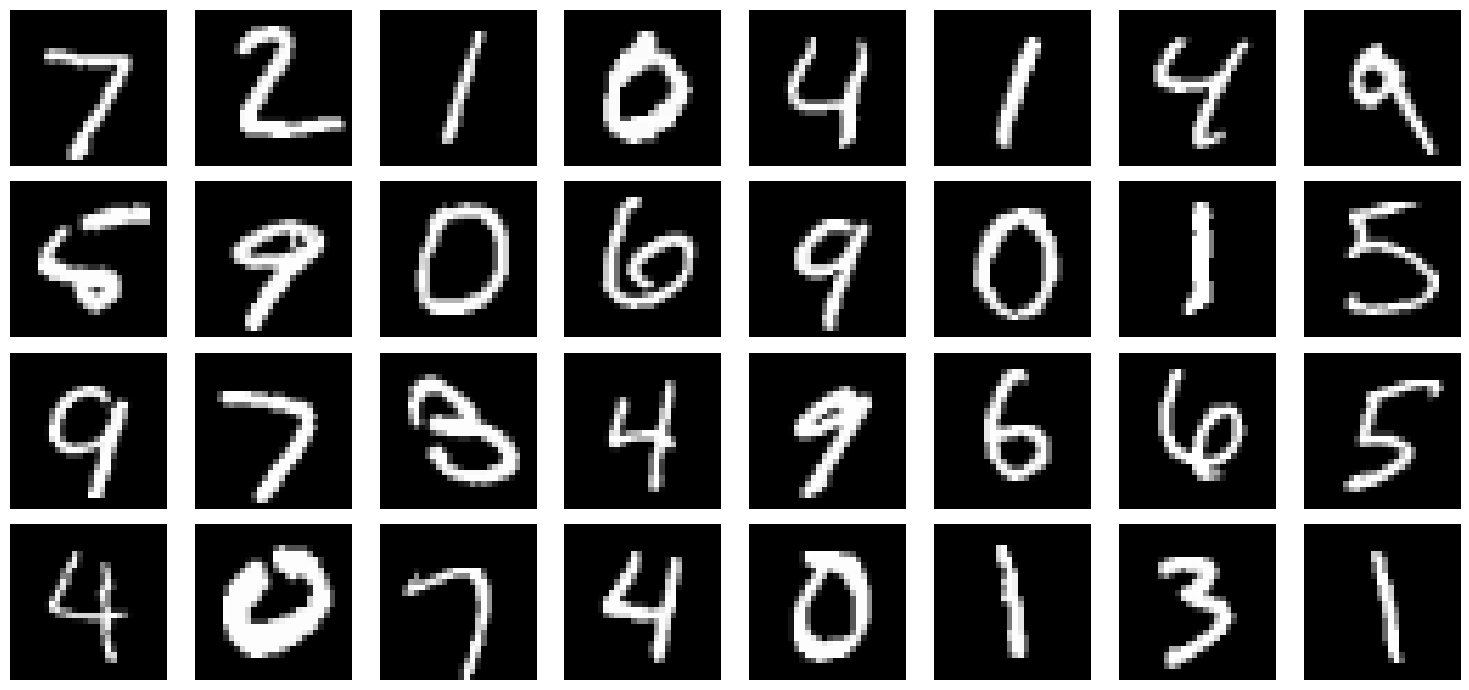

In [80]:
# Set up the plot
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(15, 7))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range(32):
    # Display image
    axes[i].imshow(images[i].squeeze(), cmap='gray')

    # Remove axis ticks
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Build Autoencoder Network

In [81]:
class Encoder(nn.Module):
    def __init__(self, dim=8):
        super().__init__()
        # Initial convolution block
        layers = [
                nn.Conv2d(1, dim, 4),
                nn.InstanceNorm2d(dim * 2),
                nn.Tanh(),
            ]

        # Downsampling
        for _ in range(4):
            layers += [
                nn.Conv2d(dim, dim * 2, 4),
                nn.InstanceNorm2d(dim * 2),
                nn.Tanh(),
            ]
            dim *= 2
        
        # Final block with 1D convolution for demonstration purposes
        layers += [
                nn.Conv2d(dim, 1, 1),
                nn.InstanceNorm2d(1),
                nn.Tanh(),
            ]

        self.model_blocks = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model_blocks(x)
        return x



class Decoder(nn.Module):
    def __init__(self, dim=8):
        super().__init__()
        dim = dim * 2 ** 3
        layers = [nn.Conv2d(1,dim,1),
                  nn.InstanceNorm2d(dim),
                  nn.LeakyReLU(0.2, inplace=True)
        ]


        # Upsampling
        for _ in range(5):
            layers += [
                nn.ConvTranspose2d(dim, dim // 2, 4),
                nn.InstanceNorm2d(dim // 2),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            dim = dim // 2

        # Output layer
        layers += [nn.Conv2d(dim, 1, 1)]

        self.model_blocks = nn.Sequential(*layers, nn.Sigmoid())

    def forward(self, x):
        x = self.model_blocks(x)
        return x


class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        code = self.encoder(x)
        out = self.decoder(code)
        return code, out

# Build training and validation loops

In [82]:
def train_loop(data_loader, ae, opt, device):
    ae.train()
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        _, recon = ae(images)
        loss = F.mse_loss(recon, images)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        _, recon = ae(images)
        loss = F.mse_loss(recon, images)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

# Train Autoencoder

In [83]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
ae = AE()
ae.to(device)
print("Number of parameters: ", sum(p.numel() for p in ae.parameters()))

opt = torch.optim.Adam(ae.parameters(), lr=3e-4)

for i in tqdm(range(5)):
    loss_rec = train_loop(train_loader, ae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(val_loader, ae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  218426


  0%|          | 0/5 [00:00<?, ?it/s]

loss from epoch  0 :  0.1538143621550666


 20%|██        | 1/5 [00:07<00:28,  7.05s/it]

test loss:  0.13595325999622104
loss from epoch  1 :  0.12153612597821614


 40%|████      | 2/5 [00:13<00:20,  6.83s/it]

test loss:  0.10956416033868548
loss from epoch  2 :  0.0988722347901163


 60%|██████    | 3/5 [00:20<00:13,  6.98s/it]

test loss:  0.0903601169208937
loss from epoch  3 :  0.08258813154748362


 80%|████████  | 4/5 [00:27<00:07,  7.00s/it]

test loss:  0.0766860266463666
loss from epoch  4 :  0.07070693026623155


100%|██████████| 5/5 [00:34<00:00,  6.92s/it]

test loss:  0.06633769428428216


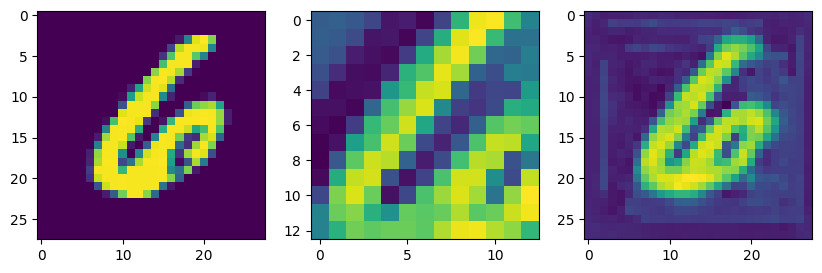

In [84]:
ae.eval()
image, label = train_dataset[737]
latent, pred = ae(image.to(device).unsqueeze(0))
# Init figure w/ subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.imshow(image.squeeze().numpy())
ax2.imshow(latent.detach().cpu().squeeze().squeeze().numpy())
ax3.imshow(pred.detach().cpu().squeeze().squeeze().numpy())

# Building a Variational Autoencoder

In [85]:
class Encoder(nn.Module):
    def __init__(self, dim=8):
        super().__init__()
        # Initial convolution block
        layers = [
                nn.Conv2d(1, dim, 4),
                nn.InstanceNorm2d(dim * 2),
                nn.Tanh(),
            ]

        # Downsampling
        for _ in range(4):
            layers += [
                nn.Conv2d(dim, dim * 2, 4),
                nn.InstanceNorm2d(dim * 2),
                nn.Tanh(),
            ]
            dim *= 2
        
        # Final block with 1D convolution for demonstration purposes
        layers += [
                nn.Conv2d(dim, 2, 1),  # THIS IS THE ONLY THING WE CHANGE IN THE NETWORK ARCH!! 
                                       # JUST OUTPUT 2X THE ORIGINAL LATENT SPACE FOR MEAN AND VAR
                nn.InstanceNorm2d(1),
                nn.Tanh(),
            ]

        self.model_blocks = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model_blocks(x)
        return x

class Decoder(nn.Module):
    def __init__(self, dim=8):
        super().__init__()
        dim = dim * 2 ** 3
        layers = [nn.Conv2d(1,dim,1),
                  nn.InstanceNorm2d(dim),
                  nn.LeakyReLU(0.2, inplace=True)
        ]


        # Upsampling
        for _ in range(5):
            layers += [
                nn.ConvTranspose2d(dim, dim // 2, 4),
                nn.InstanceNorm2d(dim // 2),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            dim = dim // 2

        # Output layer
        layers += [nn.Conv2d(dim, 1, 1)]

        self.model_blocks = nn.Sequential(*layers, nn.Sigmoid())

    def forward(self, x):
        x = self.model_blocks(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        code = self.encoder(x)
        out = self.sample(code)
        return code, out
    
    def sample(self, latent):
        mu, logvar = torch.chunk(latent, 2, dim=1)
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        sampled_posterior = eps * std + mu #  N(0,I) ~ N(0,I) * std + mu
        return self.decoder(sampled_posterior)

In [100]:
def vae_loss(recon, x, latent):
    mu, logvar = torch.chunk(latent, 2, dim=1)
    recon_loss = F.mse_loss(recon, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + (0.0001 * kl_div)

def train_loop(data_loader, ae, opt, device):
    ae.train()
    running_loss = 0.0
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        latent, recon = ae(images)
        loss = vae_loss(recon, images, latent)
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

def test_loop(data_loader, ae, device):
    ae.eval()
    running_loss = 0.
    for data in data_loader:
        images, _ = data
        images = images.to(device)
        latent, recon = ae(images)
        loss = vae_loss(recon, images, latent)
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [101]:
# locate our GPU device and initialize it for training
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# Init all of our models
vae = VAE()
vae.to(device)
print("Number of parameters: ", sum(p.numel() for p in vae.parameters()))

opt = torch.optim.Adam(vae.parameters(), lr=3e-4)

for i in tqdm(range(5)):
    loss_rec = train_loop(train_loader, vae, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    loss_rec_test = test_loop(val_loader, vae, device)
    print('test loss: ', loss_rec_test)

Number of parameters:  218555


  0%|          | 0/5 [00:00<?, ?it/s]

loss from epoch  0 :  0.48720231970660705


 20%|██        | 1/5 [00:06<00:26,  6.60s/it]

test loss:  0.3906820314594462
loss from epoch  1 :  0.3460815983832392


 40%|████      | 2/5 [00:13<00:19,  6.59s/it]

test loss:  0.3195344513352913
loss from epoch  2 :  0.28775430521649176


 60%|██████    | 3/5 [00:19<00:13,  6.59s/it]

test loss:  0.26298722700227667
loss from epoch  3 :  0.2476078882558733


 80%|████████  | 4/5 [00:26<00:06,  6.58s/it]

test loss:  0.22464747425121598
loss from epoch  4 :  0.2154671776180084


100%|██████████| 5/5 [00:32<00:00,  6.60s/it]

test loss:  0.20066981206211862


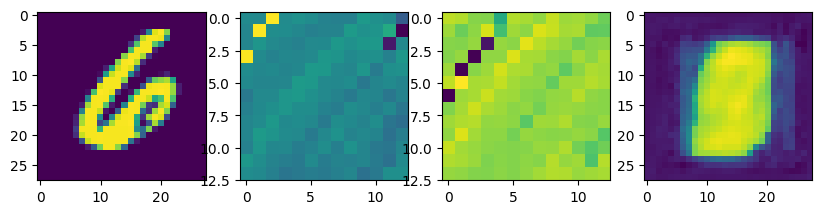

In [102]:
vae.eval()
image, label = train_dataset[737]
latent, pred = vae(image.to(device).unsqueeze(0))
# Init figure w/ subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))

ax1.imshow(image.squeeze().numpy())
ax2.imshow(latent[0][0].detach().cpu().squeeze().numpy())
ax3.imshow(latent[0][-1].detach().cpu().squeeze().squeeze().numpy())
ax4.imshow(pred.detach().cpu().squeeze().squeeze().numpy())